<a href="https://colab.research.google.com/github/soyyoon/ML_project/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 순정 모델 학습을 위한 데이터 전처리

In [ ]:
import numpy as np
import pandas as pd  # 결과 저장 및 시각화용 (학습 데이터용 아님)
import os
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# 4개의 모델 임포트
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = '/content/drive/MyDrive/ML_Project'
SAVE_PATH_TRAIN = '/content/drive/MyDrive/ML_Project/colored_mnist_train_raw.npz'
SAVE_PATH_VAL = '/content/drive/MyDrive/ML_Project/colored_mnist_val_raw.npz'

NUM_CLASSES_DIGIT = 10
NUM_CLASSES_COLOR = 7

# 데이터 로드
print("학습 데이터 로딩 중...")
train_data = np.load(SAVE_PATH_TRAIN)
X_train_color = train_data['images']
y_train_digit = train_data['labels_digit']
y_train_fg = train_data['labels_fg']
y_train_bg = train_data['labels_bg']

print("테스트 데이터 로딩 중...")
val_data = np.load(SAVE_PATH_VAL)
X_val_color = val_data['images']
y_val_digit = val_data['labels_digit']
y_val_fg = val_data['labels_fg']
y_val_bg = val_data['labels_bg']

# --- 데이터 전처리 (Numpy 사용) ---
# 1. 1차원으로 펼치기 (Flatten)
X_train_flat = X_train_color.reshape(X_train_color.shape[0], -1)
X_val_flat = X_val_color.reshape(X_val_color.shape[0], -1)

print(f"학습 데이터 Shape (Numpy): {X_train_flat.shape}")
print(f"테스트 데이터 Shape (Numpy): {X_val_flat.shape}")

Mounted at /content/drive
학습 데이터 로딩 중...
테스트 데이터 로딩 중...
학습 데이터 Shape (Numpy): (60000, 2352)
테스트 데이터 Shape (Numpy): (10000, 2352)


## 데이터 전처리 없이 모델 학습 (SVM 포함 모델 4종) -flatten 제외

In [ ]:
print("\n--- 4종 모델 학습 시작 (총 12개) ---")

training_jobs = [
    # 1. RandomForest
    ("RandomForest - Digit", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1), X_train_flat, y_train_digit),
    ("RandomForest - FG Color", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1), X_train_flat, y_train_fg),
    ("RandomForest - BG Color", RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1), X_train_flat, y_train_bg),

    # 2. XGBoost
    ("XGBoost - Digit", xgb.XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multi:softmax', eval_metric='mlogloss', num_class=NUM_CLASSES_DIGIT), X_train_flat, y_train_digit),
    ("XGBoost - FG Color", xgb.XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multi:softmax', eval_metric='mlogloss', num_class=NUM_CLASSES_COLOR), X_train_flat, y_train_fg),
    ("XGBoost - BG Color", xgb.XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multi:softmax', eval_metric='mlogloss', num_class=NUM_CLASSES_COLOR), X_train_flat, y_train_bg),

    # 3. LightGBM
    ("LightGBM - Digit", lgb.LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multiclass', num_class=NUM_CLASSES_DIGIT, verbosity=-1), X_train_flat, y_train_digit),
    ("LightGBM - FG Color", lgb.LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multiclass', num_class=NUM_CLASSES_COLOR, verbosity=-1), X_train_flat, y_train_fg),
    ("LightGBM - BG Color", lgb.LGBMClassifier(n_estimators=100, random_state=42, n_jobs=-1, objective='multiclass', num_class=NUM_CLASSES_COLOR, verbosity=-1), X_train_flat, y_train_bg),

    # 4. SVM
    # (주의: SVM 전체 데이터 학습은 시간이 매우 오래 걸릴 수 있습니다)
    ("SVM - Digit", make_pipeline(StandardScaler(), SVC(kernel='rbf', random_state=42, cache_size=1000)), X_train_flat, y_train_digit),
    ("SVM - FG Color", make_pipeline(StandardScaler(), SVC(kernel='rbf', random_state=42, cache_size=1000)), X_train_flat, y_train_fg),
    ("SVM - BG Color", make_pipeline(StandardScaler(), SVC(kernel='rbf', random_state=42, cache_size=1000)), X_train_flat, y_train_bg),
]

trained_models = {}
training_records = []

for name, model, X_train_data, y_train_data in tqdm(training_jobs, desc="Overall Training Progress"):
    start_time = time.time()
    model.fit(X_train_data, y_train_data)
    end_time = time.time()

    elapsed_time = end_time - start_time
    trained_models[name] = model

    # 결과 저장
    model_type = name.split(" - ")[0]
    target_type = name.split(" - ")[1]

    training_records.append({
        "Full Name": name,
        "Model": model_type,
        "Target": target_type,
        "Training Time (s)": elapsed_time
    })

print("\n--- 모든 모델 학습 완료 ---")


--- 4종 모델 학습 시작 (총 12개) ---


Overall Training Progress: 100%|██████████| 12/12 [1:42:30<00:00, 512.56s/it]


--- 모든 모델 학습 완료 ---


## 그레이스케일 미적용 모델 성능 평가(SVM 포함 모델 4종)


--- 최종 성능 평가 (Validation Set) ---

===== RandomForest - Digit =====
              precision    recall  f1-score   support

           0     0.9562    0.9766    0.9663       984
           1     0.9525    0.9867    0.9693       976
           2     0.9346    0.9309    0.9327      1013
           3     0.9231    0.9185    0.9208      1019
           4     0.9280    0.9391    0.9335      1002
           5     0.9368    0.9406    0.9387       993
           6     0.9435    0.9719    0.9575      1031
           7     0.9395    0.9203    0.9298       979
           8     0.9383    0.8801    0.9083       951
           9     0.9026    0.8897    0.8961      1052

    accuracy                         0.9354     10000
   macro avg     0.9355    0.9355    0.9353     10000
weighted avg     0.9352    0.9354    0.9352     10000

** Weighted-Average AUC: 0.9956 **

===== RandomForest - FG Color =====
              precision    recall  f1-score   support

           0     0.9986    1.0000    0.9993  

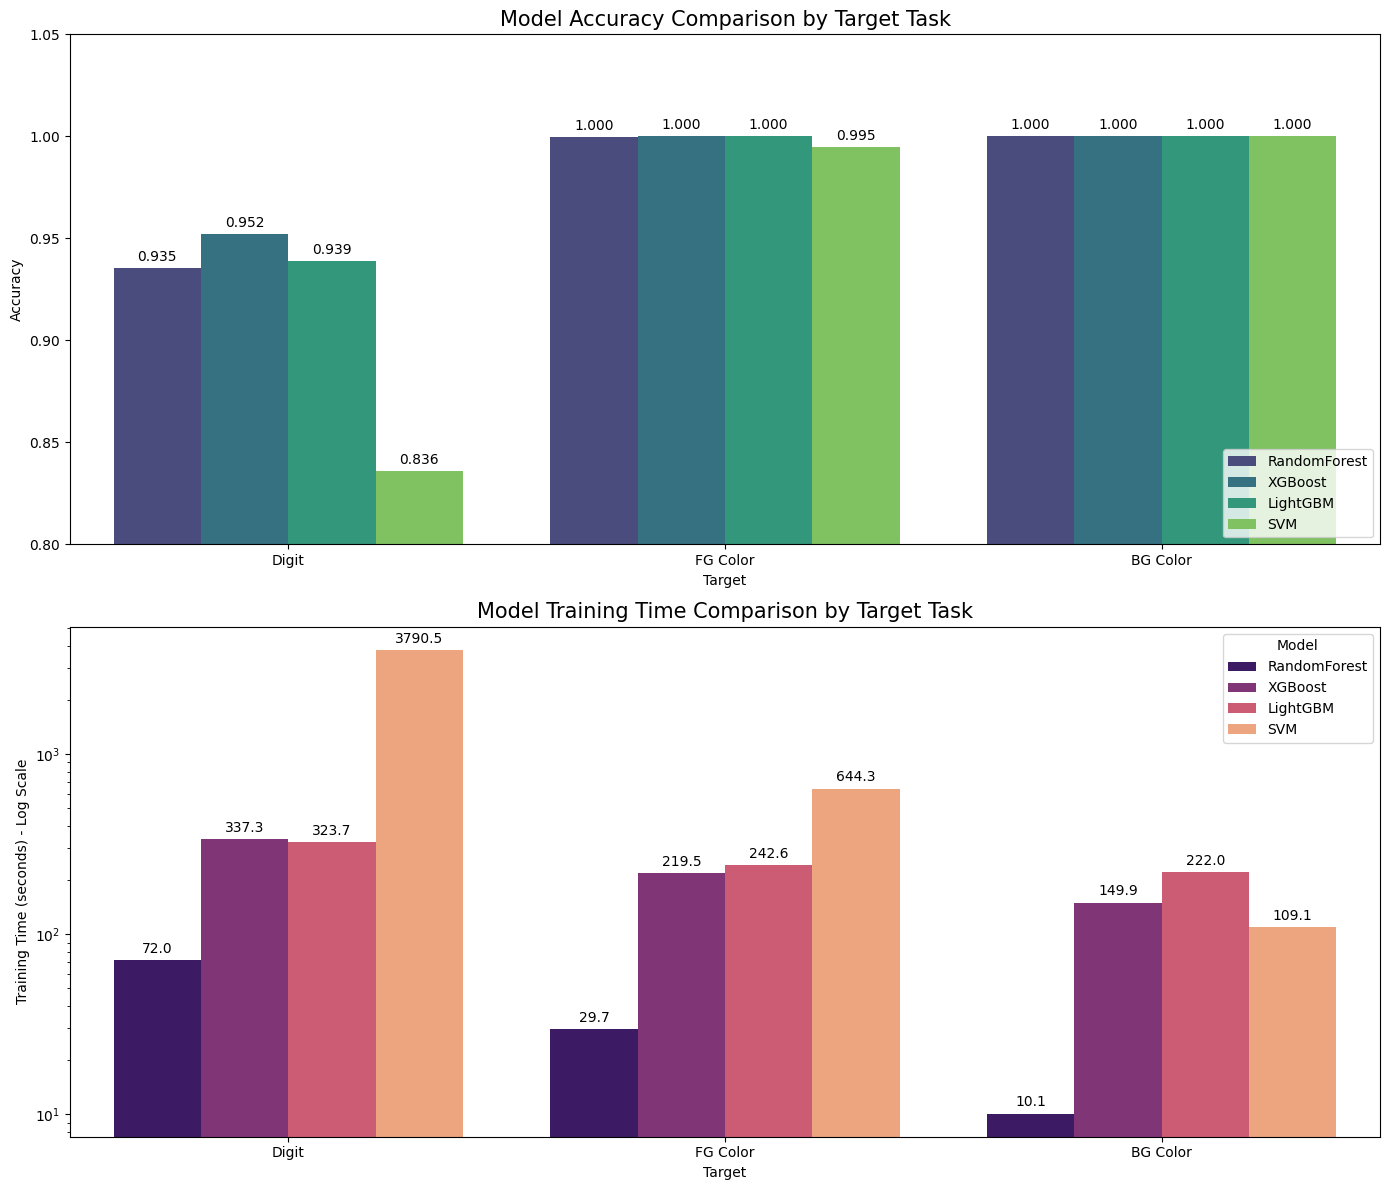


=== 종합 결과표 ===


,Full Name,Model,Target,Training Time (s),Accuracy,AUC
0,RandomForest - Digit,RandomForest,Digit,72.034474,0.9354,0.995649
1,RandomForest - FG Color,RandomForest,FG Color,29.748536,0.9997,1.000000
2,RandomForest - BG Color,RandomForest,BG Color,10.099347,1.0000,1.000000
3,XGBoost - Digit,XGBoost,Digit,337.307904,0.9519,0.997227
4,XGBoost - FG Color,XGBoost,FG Color,219.466420,1.0000,1.000000
5,XGBoost - BG Color,XGBoost,BG Color,149.896379,1.0000,1.000000
6,LightGBM - Digit,LightGBM,Digit,323.661014,0.9388,0.995687
7,LightGBM - FG Color,LightGBM,FG Color,242.649291,1.0000,1.000000
8,LightGBM - BG Color,LightGBM,BG Color,222.014463,1.0000,1.000000
9,SVM - Digit,SVM,Digit,3790.472866,0.8360,0.000000


In [ ]:
import warnings

def evaluate_and_record(model_name, model_obj, records_list):
    print(f"\n===== {model_name} =====")

    # 1. 모델 이름에 따라 평가 데이터 선택 (Numpy 배열인 X_val_flat 사용)
    if "Digit" in model_name:
        X_val, y_val = X_val_flat, y_val_digit
    elif "FG Color" in model_name:
        X_val, y_val = X_val_flat, y_val_fg
    else: # BG Color
        X_val, y_val = X_val_flat, y_val_bg

    # 2. 예측
    y_pred = model_obj.predict(X_val)

    # 3. 성능 지표 계산
    acc = accuracy_score(y_val, y_pred)
    # zero_division=0 추가하여 경고 방지
    print(classification_report(y_val, y_pred, digits=4, zero_division=0))

    # 4. AUC 계산
    auc = None
    estimator = model_obj
    if hasattr(model_obj, 'steps'): # 파이프라인(SVM) 처리
        estimator = model_obj.steps[-1][1]

    if hasattr(estimator, "predict_proba") and getattr(estimator, "probability", True):
        try:
            y_proba = model_obj.predict_proba(X_val)
            auc = roc_auc_score(y_val, y_proba, multi_class='ovr', average='weighted')
            print(f"** Weighted-Average AUC: {auc:.4f} **")
        except:
            pass

    # 5. 기록 업데이트
    for record in records_list:
        if record["Full Name"] == model_name:
            record["Accuracy"] = acc
            record["AUC"] = auc if auc is not None else 0
            break

print("\n--- 최종 성능 평가 (Validation Set) ---")

# 모든 경고가 아니라, 'Feature names' 관련 경고만 골라서 무시
with warnings.catch_warnings():
    # 1. LightGBM/Sklearn의 "X does not have valid feature names" 경고만 무시
    warnings.filterwarnings("ignore", message=".*X does not have valid feature names.*")

    # (선택 사항) "UndefinedMetricWarning" (0으로 나누기 경고)도 무시하고 싶다면 아래 주석 해제
    # warnings.filterwarnings("ignore", message=".*Precision and F-score are ill-defined.*")

    # 2. 그 외의 다른 경고(치명적인 경고 포함)는 정상적으로 출력됩니다.
    for name, model in trained_models.items():
        evaluate_and_record(name, model, training_records)

# --- 시각화 (학습 시간 & 정확도 비교) ---
df_results = pd.DataFrame(training_records)

fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# 1. 정확도 비교
sns.barplot(data=df_results, x="Target", y="Accuracy", hue="Model", ax=axes[0], palette="viridis")
axes[0].set_title("Model Accuracy Comparison by Target Task", fontsize=15)
axes[0].set_ylim(0.8, 1.05)
axes[0].legend(loc='lower right')
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.3f', padding=3)

# 2. 학습 시간 비교
sns.barplot(data=df_results, x="Target", y="Training Time (s)", hue="Model", ax=axes[1], palette="magma")
axes[1].set_title("Model Training Time Comparison by Target Task", fontsize=15)
axes[1].set_yscale("log") # 로그 스케일 사용
axes[1].set_ylabel("Training Time (seconds) - Log Scale")
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.1f', padding=3)

plt.tight_layout()
plt.show()

print("\n=== 종합 결과표 ===")
display(df_results)

## 혼동행렬 출력

--- Confusion Matrix 생성 중 ---


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


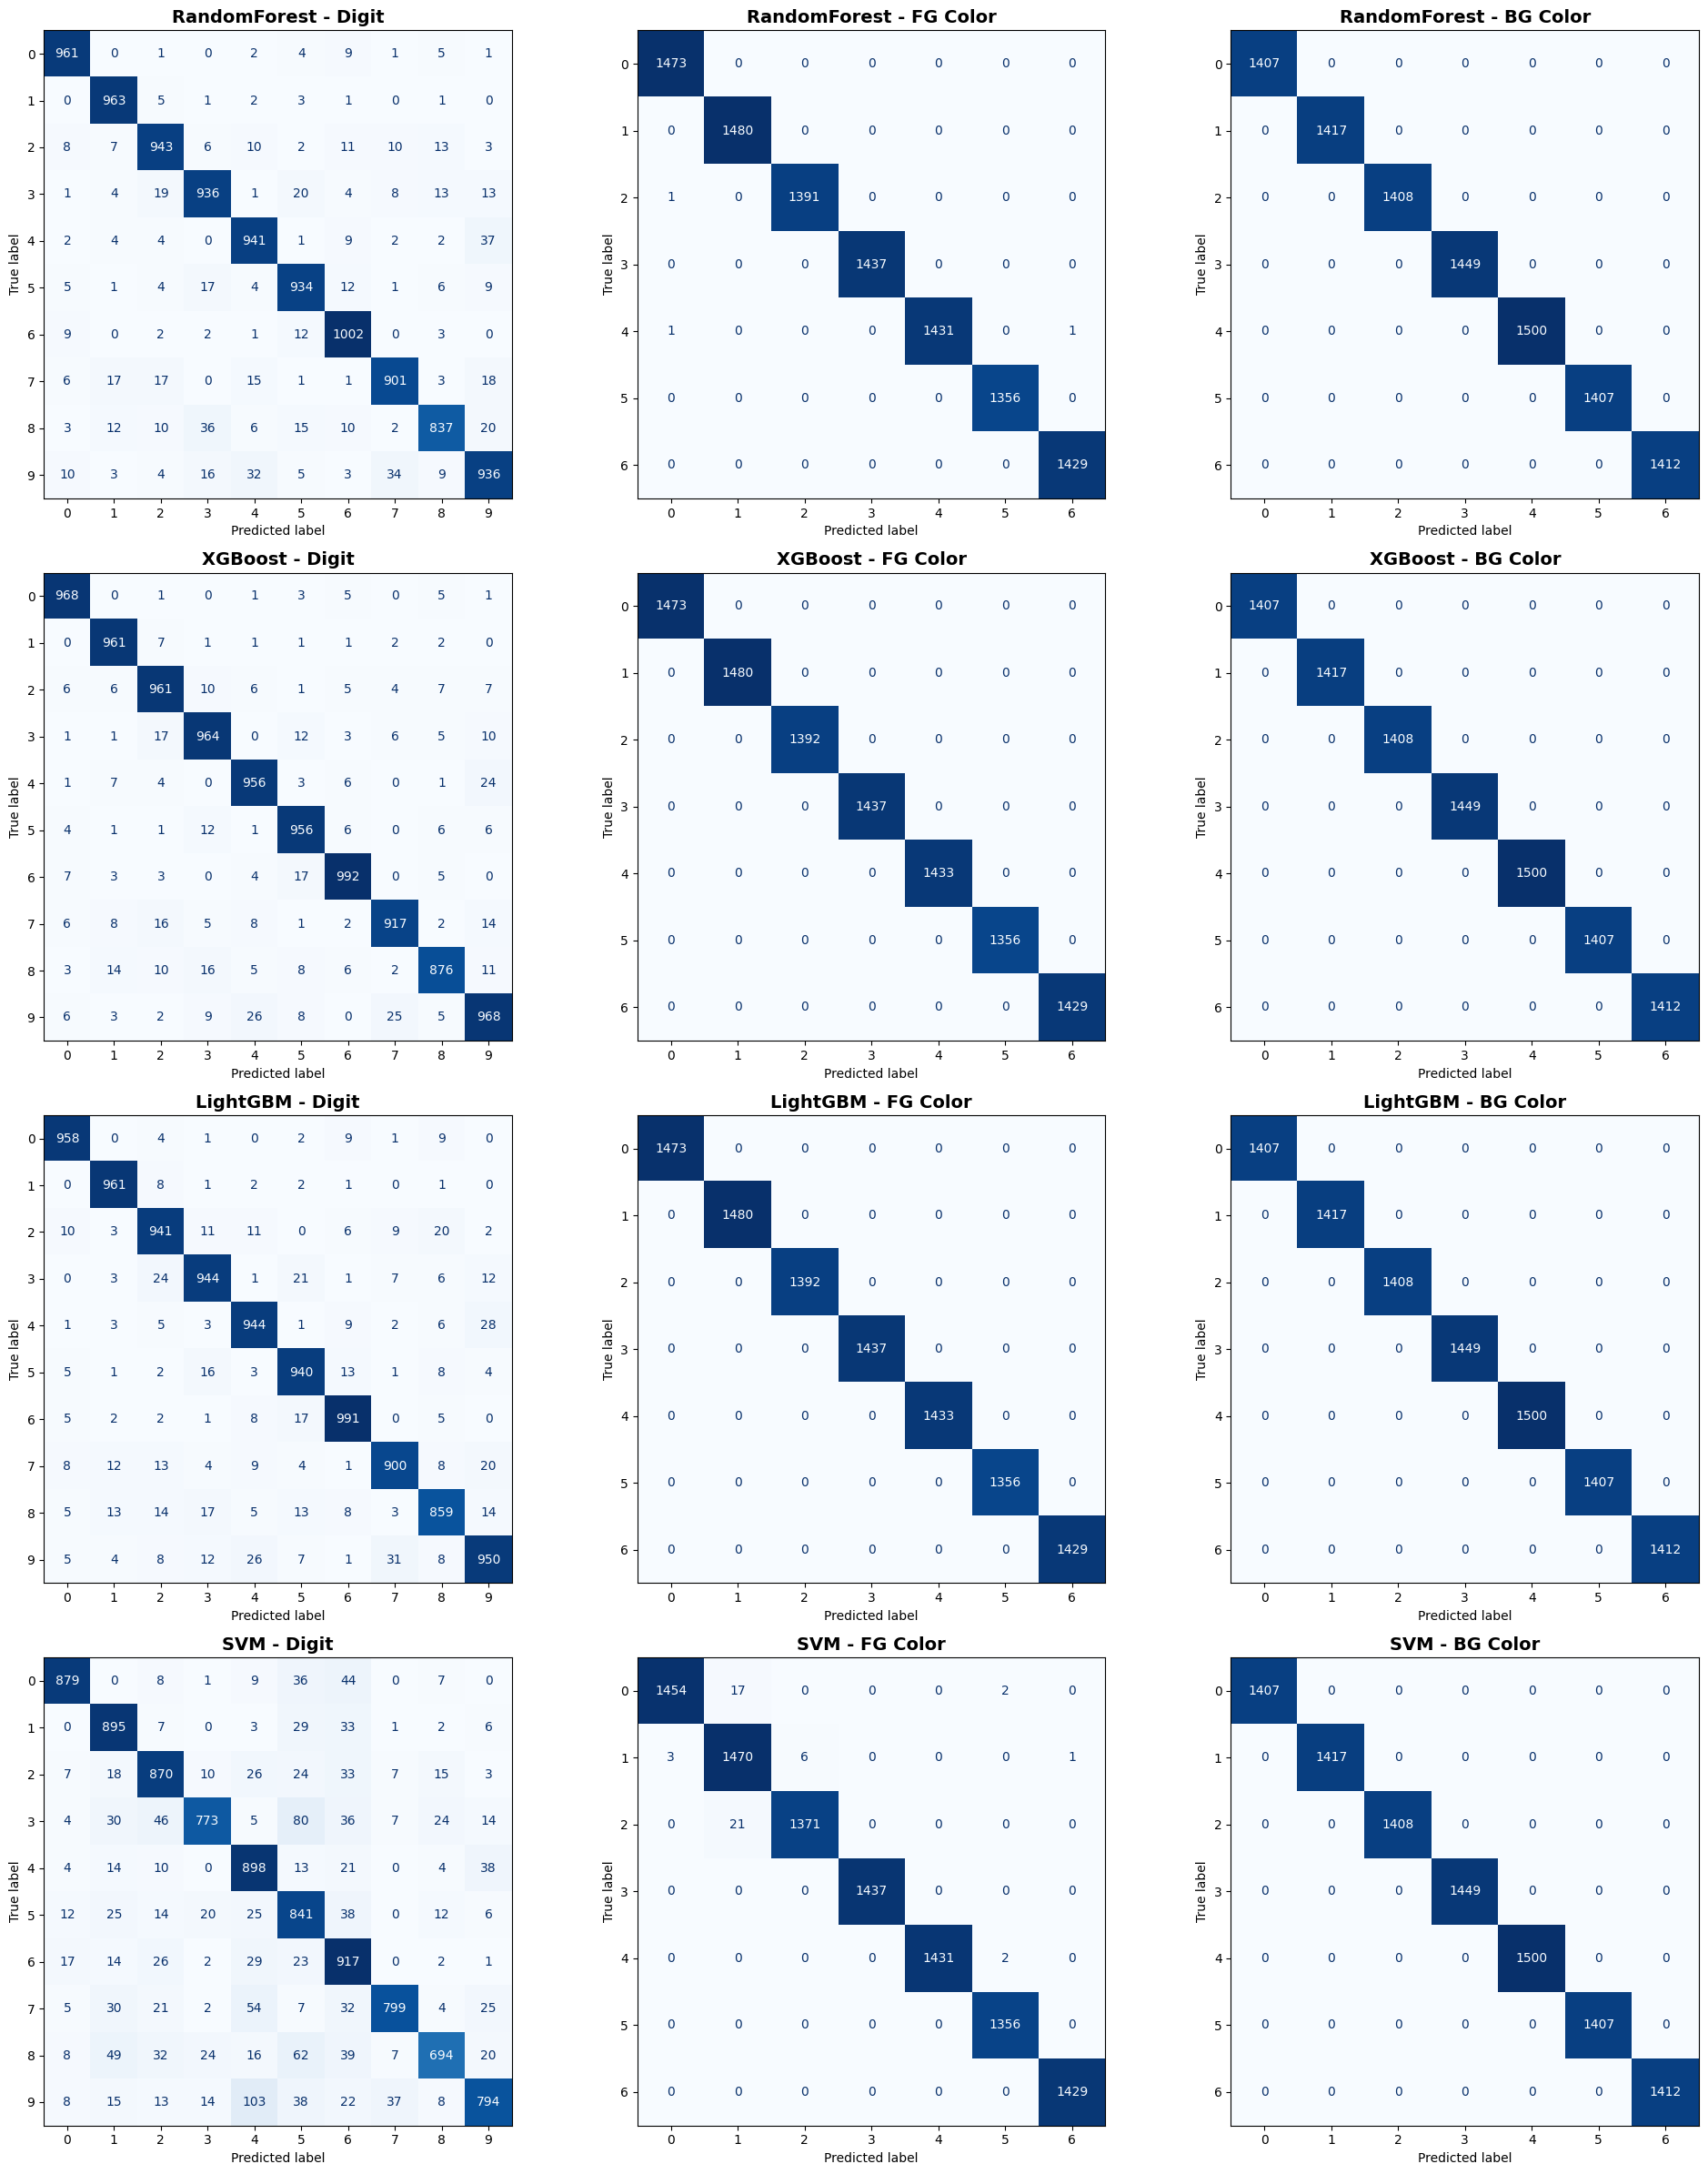

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# 1. 그래프 틀 잡기 (4개 모델 x 3개 태스크 = 12개 서브플롯)
fig, axes = plt.subplots(4, 3, figsize=(20, 24)) # 사이즈는 넉넉하게
axes = axes.flatten() # for문 돌리기 편하게 1차원으로 쫙 펴기

print("--- Confusion Matrix 생성 중 ---")

# 2. 저장된 모델 하나씩 꺼내서 평가하기
# trained_models 딕셔너리에 저장된 순서대로 가져옴
for i, (name, model) in enumerate(trained_models.items()):

    # 현재 모델 이름에 따라 적절한 테스트 데이터 선택 (매칭 룰)
    if "Digit" in name:
        X_val = X_val_flat
        y_val = y_val_digit
    elif "FG Color" in name: # 전경색
        X_val = X_val_flat
        y_val = y_val_fg
    elif "BG Color" in name: # 배경색
        X_val = X_val_flat
        y_val = y_val_bg
    else:
        print(f"Error: {name}에 맞는 데이터를 못 찾겠어!")
        continue

    # 예측 수행
    y_pred = model.predict(X_val)

    # Confusion Matrix 계산
    cm = confusion_matrix(y_val, y_pred)

    # 시각화 (Plot)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    # values_format='d': 과학적 표기법(1e2) 말고 정수(100)로 보여줌.
    disp.plot(ax=axes[i], cmap='Blues', values_format='d', colorbar=False)

    # 제목 달기
    axes[i].set_title(f"{name}", fontsize=14, fontweight='bold')

# 레이아웃 깔끔하게 정리
plt.tight_layout()
plt.show()